In [2]:
import warnings
warnings.filterwarnings('ignore')

# LightGBM

`LightGBM`
* XGBoost와 함께 Gradient Boost Machine(GBM) 기반 대표 알고리즘이다.
* 'light'라는 이름처럼 LightGBM은 XGBoost보다 더 빠른 연산이 가능하고 메모리도 적게 사용한다. 그러한 측면에서 대용량 데이터 셋 사용시 효율적이다.
    - GBM계열 대부분이 균형 트리 분할 방식을 사용하는 것과 달리, LightGBM은 리프 중심 트리 분할을 사용한다. 이를 통해 실행 시간을 단축시킬 수 있다.
* 그러나 너무 작은 데이터 셋에서는 과적합 가능성이 높다.

  

## 1) 유방암 데이터로 실습하기

### 1-1. 유방암 데이터 생성

위스콘신 대학교에서 제공한 유방암 진단결과 데이터이다.  

feature  
* 양성(benign, 0)과 악성(malignant, 1)을 구분할 수 있는 종양의 크기, 모양 등의 다양한 특성값을 가진다.
* `mean_` : 1 ~ 10번째 feature는 특성별 평균값을 의미한다.
* `_error` : 11 ~ 20번째 feature는 특성별 표준오차(Standard Error)를 의미한다.
* `worst_` : 21 ~ 30번째까지는 각 종양의 특성들에서 제일 큰 3개의 값을 평균낸 값을 의미한다.


<a title="Preethi Sekar, Jyotsna Naresh Bharti, Jitendra Singh Nigam, Ankit Sharma, and Priyanka Bhatia Soni, CC BY 3.0 &lt;https://creativecommons.org/licenses/by/3.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg"><img width="512" alt="Micrograph of ductal carcinoma with marked nuclear pleomorphism and increased mitotic rate" src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/f8/Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg/512px-Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg"></a>

<a href="https://commons.wikimedia.org/wiki/File:Micrograph_of_ductal_carcinoma_with_marked_nuclear_pleomorphism_and_increased_mitotic_rate.jpg">Preethi Sekar, Jyotsna Naresh Bharti, Jitendra Singh Nigam, Ankit Sharma, and Priyanka Bhatia Soni</a>, <a href="https://creativecommons.org/licenses/by/3.0">CC BY 3.0</a>, via Wikimedia Commons

In [3]:
# !pip install lightgbm

In [4]:
# 라이브러리 import
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

import lightgbm as lgb

from matplotlib import pyplot as plt
from lightgbm import plot_importance
from lightgbm import plot_tree

from sklearn.metrics import classification_report

In [5]:
lgb_model = lgb.LGBMClassifier()

In [6]:
dir(lgb.LGBMClassifier())

['_Booster',
 '_LGBMClassifier__is_multiclass',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__sklearn_clone__',
 '__sklearn_is_fitted__',
 '__sklearn_tags__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_base_doc',
 '_best_iteration',
 '_best_score',
 '_build_request_for_signature',
 '_class_map',
 '_class_weight',
 '_classes',
 '_doc_link_module',
 '_doc_link_template',
 '_doc_link_url_param_generator',
 '_estimator_type',
 '_evals_result',
 '_get_default_requests',
 '_get_doc_link',
 '_get_metadata_request',
 '_get_param_names',
 '_get_params_html',
 '_html_repr',
 '_more_tags',
 '_n_classes',
 '_n_features',
 '_n_features_i

In [7]:
# 유방암 data를 불러온 후, cancer 변수에 담아보자.
cancer = load_breast_cancer()

# 유방암 data를 학습용과 검증용 데이터 세트로 분리해보자.
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                   stratify = cancer.target,
                                                   shuffle = True)

### 1-2. LightGBM Classifier 생성

`LightGBM(max_depth, n_estimatros, learning_rate, boosting_type, reg_alpha, reg_lambda`)
- LightGBM 역시 사이킷런에서 제공하지 않기 떄문에 별도의 설치가 필요하다.  
- https://lightgbm.readthedocs.io/en/latest/index.html (LightGBM 공식문서)를 참고하여 설치



주요 paramter
- xgboost의 파라미터와 거의 동일  
- `max_depth` : 트리의 깊이를 조정하는 파라미터, XGBoost와 다르게 리프 노드가 계속 분할되기 때문에 max_depth를 크게 설정하여야 함, (기본 값=-1)   
- `n_estimators` : 반복할 결정 트리의 개수, (기본 값=9)
- `learning_rate` : 학습기 마다 가중치를 얼마나 줄 것인지를 설정하는 파라미터, (기본 값=0.1)
- `boosting_type` : xgboost의 booster파라미터와 같은 역할을 하지만 지원하는 모델이 다르다, `gbdt(Gradient Boosted Decision Trees)`, `rf(Random Forest)`, `dart`, `goss(Gradient-based One-Sied Sampling)`가 있다.  
    - goss는 계산속도를 줄여 주지만 예측력에서 손실이 있을 수 있다.  
- `reg_alpha` : L1 규제  
- `reg_lambda` : L2 규제

In [8]:
# LGBM classifier을 로드한 뒤 학습시켜보자.
lgb_model = lgb.LGBMClassifier(max_depth=5, n_estimators=9,
                               learning_rate=0.1)

In [9]:
# lgb_model의 paramter 값을 조회할 수 있다.
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 267, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4272
[LightGBM] [Info] Number of data points in the train set: 426, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.626761 -> initscore=0.518344
[LightGBM] [Info] Start training from score 0.518344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,5
,learning_rate,0.1
,n_estimators,9
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### 1-3. 모델 검증

In [10]:
# 모델 성능을 출력해보자.
print(f'train : {lgb_model.score(X_train, y_train)}')
print(f'test : {lgb_model.score(X_test, y_test)}')
print(f'report : \n {classification_report(y_test, lgb_model.predict(X_test))}')

train : 0.9741784037558685
test : 0.972027972027972
report : 
               precision    recall  f1-score   support

           0       1.00      0.92      0.96        53
           1       0.96      1.00      0.98        90

    accuracy                           0.97       143
   macro avg       0.98      0.96      0.97       143
weighted avg       0.97      0.97      0.97       143



In [11]:
# 검증용 X data에 대한 lgb_model의 예측값을 확인해보자.
lgb_model.predict(X_test)

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1])

In [12]:
# 검증용 X data에 대한 lgb_model의 각 클래스에 대한 확률을 확인해보자.
lgb_model.predict_proba(X_test)

array([[0.16636536, 0.83363464],
       [0.16955134, 0.83044866],
       [0.31149036, 0.68850964],
       [0.14878302, 0.85121698],
       [0.14857344, 0.85142656],
       [0.14775334, 0.85224666],
       [0.7472627 , 0.2527373 ],
       [0.14869595, 0.85130405],
       [0.42772972, 0.57227028],
       [0.62415474, 0.37584526],
       [0.4654499 , 0.5345501 ],
       [0.76306339, 0.23693661],
       [0.27186845, 0.72813155],
       [0.14878302, 0.85121698],
       [0.47367792, 0.52632208],
       [0.29389405, 0.70610595],
       [0.36391124, 0.63608876],
       [0.75536607, 0.24463393],
       [0.14878302, 0.85121698],
       [0.59427715, 0.40572285],
       [0.14713883, 0.85286117],
       [0.2958313 , 0.7041687 ],
       [0.481789  , 0.518211  ],
       [0.15197186, 0.84802814],
       [0.14878302, 0.85121698],
       [0.14878302, 0.85121698],
       [0.15149923, 0.84850077],
       [0.7553315 , 0.2446685 ],
       [0.14858236, 0.85141764],
       [0.14858236, 0.85141764],
       [0.

### 1-4. 모델 시각화

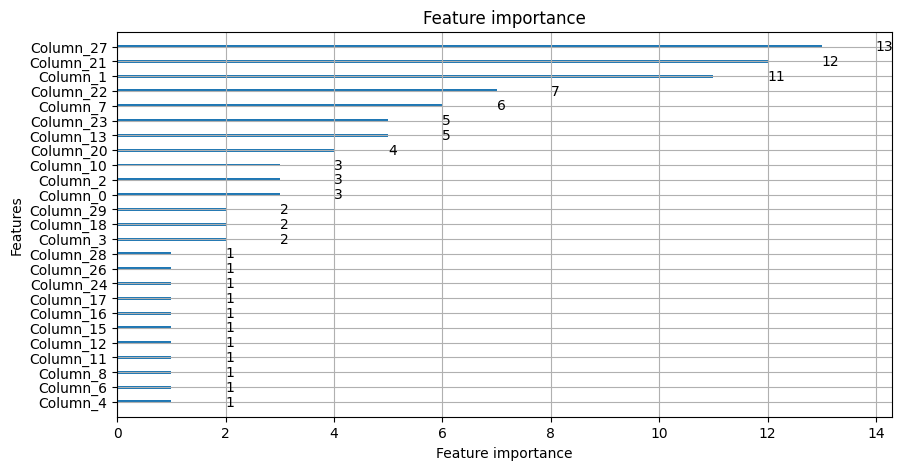

In [13]:
# LGBM의 plot_importance() API를 활용하여 특성 중요도를 시각화해보자.
fig, ax = plt.subplots(figsize = (10, 5))
plot_importance(lgb_model, ax=ax)
plt.show()

- XGBoost와 동일하게 plot_importance로 특성들의 유효성을 확인할 수 있다.

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

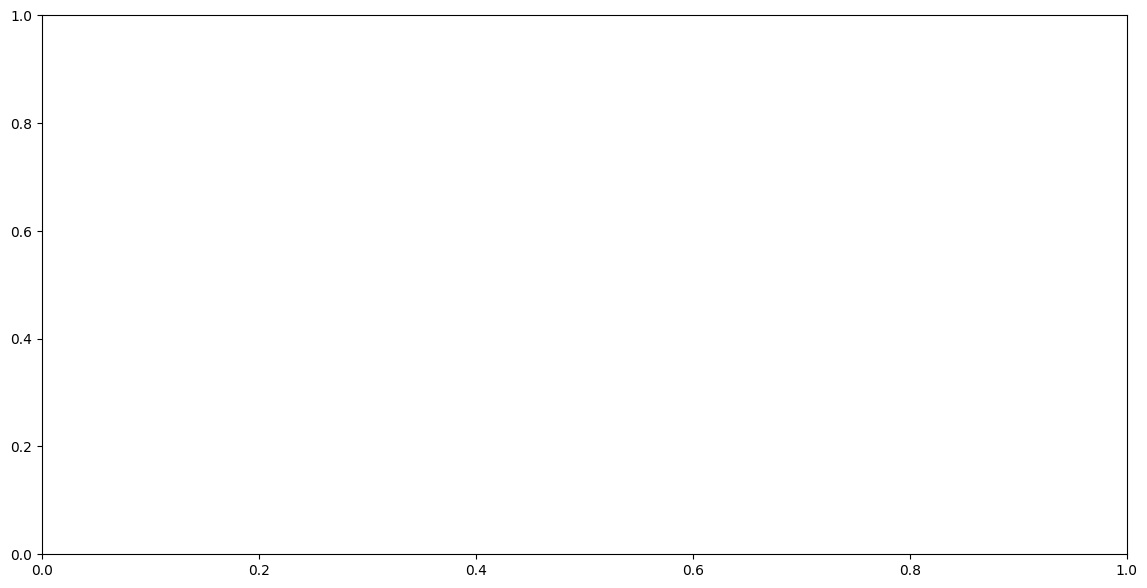

In [14]:
# plot_tree를 이용하여 decision tree를 시각화해보자.
fig, ax = plt.subplots(figsize=(14,7))
plot_tree(lgb_model, ax=ax)
plt.show()

- plot_tree를 이용해서 LightGBM의 트리구조를 시각화할 수 있다.
* 비대칭적인 트리가 만들어진 것을 확인할 수 있다.

## 2) 와인 데이터로 실습하기

3개의 포도 품종으로 만든 와인의 13개의 외관 및 성분적인 특성(feature) 값을 측정한 데이터이다.

feature  
* `alcohol` : 알콜 도수
* `malic_acid` : 말산
* `ash` : 재
* `alcalinity_of_ash` : 알칼리도
* `magnesium` : 마그네슘
* `total_phenols` : 전체 페놀
* `flavanoids` : 플라보노이드 페놀
* `nonflavanoid_phenols` : 비플라보노이드 페놀
* `proanthocyanins` : 프로안토시아니딘
* `color_intensity` : 색도
* `hue` : 빛깔, 색조
* `od280/od315_of_diluted_wines` : 희석된 와인의 od280/od315 비율
* `proline` : 프롤린


<a title="Swedish Pavilion at Shanghai Expo 2010, CC BY 2.0 &lt;https://creativecommons.org/licenses/by/2.0&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Bengt_Frithiofsson_evaluating_wine.jpg"><img width="512" alt="Bengt Frithiofsson evaluating wine" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/15/Bengt_Frithiofsson_evaluating_wine.jpg/512px-Bengt_Frithiofsson_evaluating_wine.jpg"></a>  

<a href="https://commons.wikimedia.org/wiki/File:Bengt_Frithiofsson_evaluating_wine.jpg">Swedish Pavilion at Shanghai Expo 2010</a>, <a href="https://creativecommons.org/licenses/by/2.0">CC BY 2.0</a>, via Wikimedia Commons

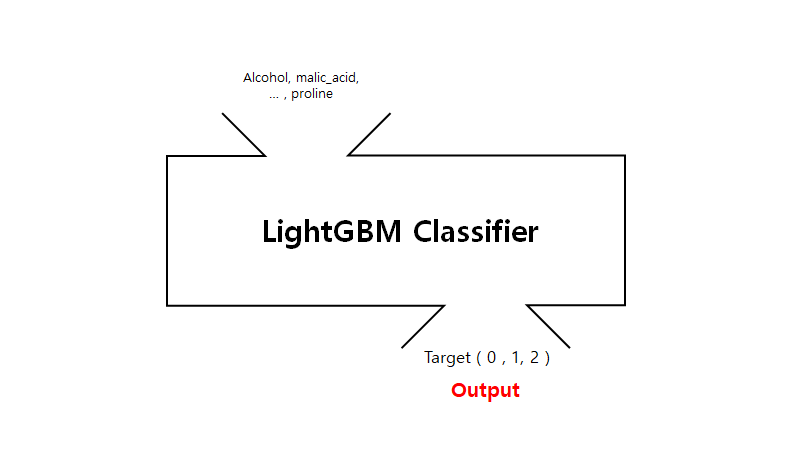

###2-1. 와인 데이터 생성

In [15]:
# wine data를 불러온 후, wine 변수에 담아보자.
wine = load_wine()

# wine data를 학습용과 검증용 데이터 세트로 분리해보자.
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target,
                                                    test_size=0.3, shuffle=True)

### 2-2. LightGMB Classifier 생성

In [21]:
# LightGBM classifier을 로드한 뒤 학습시켜보자.
lgb_model = lgb.LGBMClassifier(max_depth=3, n_estimators=50,
                               learning_rate=0.01).fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 124, number of used features: 13
[LightGBM] [Info] Start training from score -1.106709
[LightGBM] [Info] Start training from score -0.949081
[LightGBM] [Info] Start training from score -1.264934
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

In [22]:
# xgb_model의 paramter 값을 조회해보자.


### 2-3. 모델 검증

In [23]:
# 모델 성능을 출력해보자.
lgb_model.score(X_train, y_train)

0.9758064516129032

In [24]:
lgb_model.score(X_test, y_test)

0.9259259259259259

In [25]:
print(classification_report(y_test, lgb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        18
           1       0.95      0.91      0.93        23
           2       0.86      0.92      0.89        13

    accuracy                           0.93        54
   macro avg       0.92      0.93      0.92        54
weighted avg       0.93      0.93      0.93        54



In [26]:
# 검증용 X data에 대한 lgb_model의 예측값을 확인해보자.
lgb_model.predict(X_test)

array([0, 0, 1, 1, 1, 1, 2, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 0, 0, 2, 0, 1,
       2, 1, 0, 1, 1, 1, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 0, 0, 1, 1, 1, 0,
       2, 2, 0, 2, 2, 0, 1, 0, 1, 0])

In [27]:
# 검증용 X data에 대한 lgb_model의 각 클래스에 대한 확률을 확인해보자.
lgb_model.predict_proba(X_test)

array([[0.59531382, 0.23726178, 0.16742441],
       [0.62057455, 0.21387377, 0.16555168],
       [0.19446481, 0.64763855, 0.15789665],
       [0.19935311, 0.63904727, 0.16159962],
       [0.18844494, 0.64000927, 0.17154579],
       [0.19029132, 0.64628007, 0.16342862],
       [0.23033296, 0.2555239 , 0.51414315],
       [0.18386513, 0.64875819, 0.16737668],
       [0.52389171, 0.28402449, 0.1920838 ],
       [0.56847077, 0.28211837, 0.14941086],
       [0.22387662, 0.28210578, 0.4940176 ],
       [0.1878673 , 0.6454884 , 0.1666443 ],
       [0.35199469, 0.51521165, 0.13279366],
       [0.54790441, 0.28776378, 0.16433181],
       [0.29031843, 0.44147475, 0.26820681],
       [0.20591179, 0.23471684, 0.55937137],
       [0.2237864 , 0.24588094, 0.53033266],
       [0.53783347, 0.26539503, 0.1967715 ],
       [0.54978733, 0.29254282, 0.15766985],
       [0.21458745, 0.34200046, 0.44341209],
       [0.52249581, 0.25014044, 0.22736375],
       [0.1920699 , 0.64712243, 0.16080767],
       [0.

In [30]:
import numpy as np
np.sum(lgb_model.predict_proba(X_test), axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

### 2-4. 모델 시각화

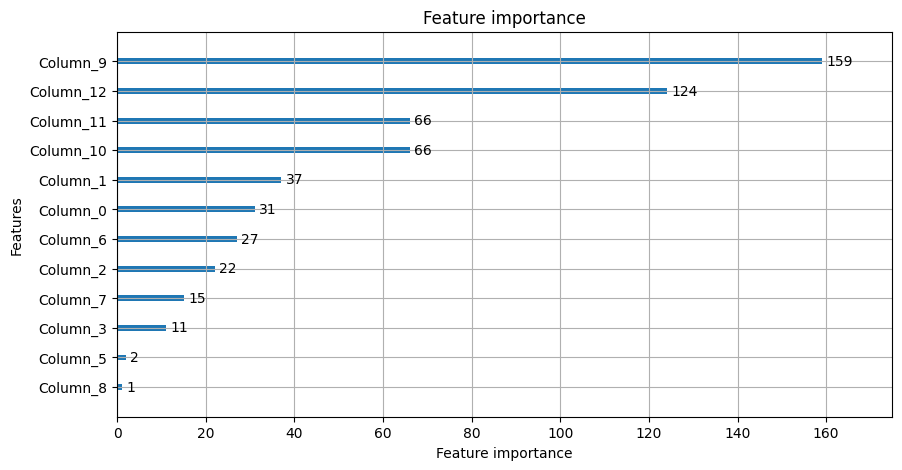

In [31]:
#LGBM의 plot_importance() API를 활용하여 특성 중요도를 시각화해보자.
fig, ax = plt.subplots(figsize=(10,5))
plot_importance(lgb_model, ax=ax)
plt.show()

In [33]:
lgb_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,3
,learning_rate,0.01
,n_estimators,50
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

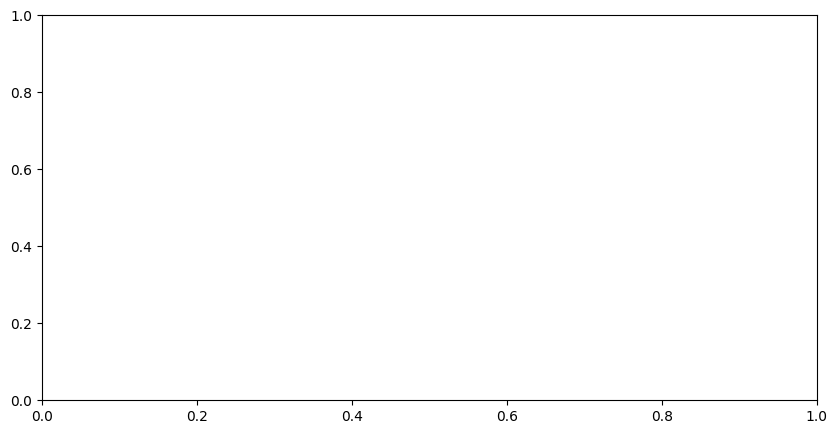

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))
plot_tree(lgb_model, ax=ax)
plt.show()

In [ ]:
# plot_tree를 이용하여 decision tree를 시각화해보자.
